<a href="https://colab.research.google.com/github/sayakpaul/Image-Adversaries-101/blob/master/GANs_w_Adversaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import TensorFlow as verify the version
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [2]:
# Which GPU?
!nvidia-smi

Fri Apr 17 13:39:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import build_montages
from sklearn.utils import shuffle 
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
# Load data
((X_train, _), (X_test, _)) = tf.keras.datasets.fashion_mnist.load_data()
X_train.shape, X_test.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [0]:
# Add a channel dimension so that it is compatible with Conv2D
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [0]:
# Combine the train and test images and scale the the image pixel values to [-1, 1]
trainImages = np.concatenate([X_train, X_test])
trainImages = (trainImages.astype("float") - 127.5) / 127.5

In [0]:
# Define the Hyperparameters
latent_dim = 100
height = 28
width = 28
nb_channels = 1

In [0]:
# Generator
def generator_network():
    generator = Sequential()
    inputShape = (7, 7, 64)
    chanDim = -1

    generator.add(Dense(input_dim=latent_dim, units=512))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Dense(7 * 7 * 64))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Reshape(inputShape))
    generator.add(Conv2DTranspose(32, (5, 5), strides=(2, 2),
        padding="same"))
    generator.add((LeakyReLU()))
    generator.add(BatchNormalization(axis=chanDim))

    generator.add(Conv2DTranspose(nb_channels, (5, 5), strides=(2, 2),
        padding="same", activation="tanh"))

    return generator

In [9]:
# Instantiate the Generator network
generator = generator_network()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              1608768   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0

In [0]:
# Discriminator
def disc_network():
    disc = Sequential()
    inputShape = (height, width, nb_channels)

    disc.add(Conv2D(32, (5, 5), padding="same", strides=(2, 2),
        input_shape=inputShape))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Conv2D(64, (5, 5), padding="same", strides=(2, 2)))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Flatten())
    disc.add(Dense(512))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Dropout(0.3))
    disc.add(Dense(1))
    disc.add(Activation("sigmoid"))
    
    return disc

In [11]:
# Instantiate the Discriminator network
disc = disc_network()
disc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1606144   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)              

In [0]:
# Optimizer for the Disc
disc_opt = tf.keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
disc.compile(optimizer=disc_opt, loss="binary_crossentropy")

In [0]:
# GAN
disc.trainable = False
gan_input = Input(shape=(latent_dim, ))
gan_output = disc(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_opt = tf.keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
gan.compile(loss="binary_crossentropy", optimizer=gan_opt)

In [14]:
# Summary of the GAN architecture
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         1727233   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1658753   
Total params: 3,385,986
Trainable params: 1,719,873
Non-trainable params: 1,666,113
_________________________________________________________________


In [0]:
# More hyperparameters
epochs = 10000
batch_size = 20

In [16]:
# Start training
################
start = 0
for epoch in tqdm(range(epochs)):
    # Sample random noise from a normal distribution
    benchmark_noise = np.random.normal(size=(batch_size, latent_dim))
    # Map this noise to images via the generator network
    generated_images = generator.predict(benchmark_noise)
    
    # Calculate where to stop the current epoch, segregate the current batch
    # of real images and combine them with the fake ones
    stop = start + batch_size
    real_images = trainImages[start:stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # 1 -> Fake images, 0 -> Real images
    # Add a bit of random noise to the labels
    labels = np.array(([1] * batch_size) + ([0] * batch_size)).astype("float")
    labels += 0.05 * np.random.random(labels.shape)
    
    # Shuffle the datapoints of the newly created dataset
    (combined_images, labels) = shuffle(combined_images, labels)
    
    # Train the discriminator on these new dataset
    d_loss = disc.train_on_batch(combined_images, labels)
    
    # Again sample random noise from a normal distribution &
    # set the labels to such that they resemble real images to fool
    # discriminator
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    fake_labels = np.array([0] * batch_size)
    
    # Train the GAN with this random noise and fake labels, but only
    # update the weights of generator
    a_loss = gan.train_on_batch(random_latent_vectors, fake_labels)
    
    # Set the next batch
    start += batch_size
    if start > len(trainImages) - batch_size:
        start = 0
    
    # Logging
    if epoch % 500 == 0:
        print(f"Step: {epoch} Disc Loss: {d_loss} Adv Loss: {a_loss}")
        images = ((generated_images * 127.5) + 127.5).astype("int")
        images = np.repeat(images, 3, axis=-1)
        vis = build_montages(images, (28, 28), (4, 5))[0]
        cv2.imwrite("vis" + str(epoch) + ".png", vis)

  0%|          | 3/10000 [00:08<17:03:54,  6.15s/it]

Step: 0 Disc Loss: 0.687881350517273 Adv Loss: 0.14508673548698425


  5%|▌         | 503/10000 [00:33<07:38, 20.73it/s]

Step: 500 Disc Loss: 0.47640880942344666 Adv Loss: 1.350799798965454


 10%|█         | 1003/10000 [00:57<07:16, 20.63it/s]

Step: 1000 Disc Loss: 0.49821704626083374 Adv Loss: 1.7119624614715576


 15%|█▌        | 1504/10000 [01:21<07:10, 19.76it/s]

Step: 1500 Disc Loss: 0.49107104539871216 Adv Loss: 1.8809871673583984


 20%|██        | 2003/10000 [01:46<06:39, 20.03it/s]

Step: 2000 Disc Loss: 0.536552906036377 Adv Loss: 2.172856569290161


 25%|██▌       | 2503/10000 [02:10<06:07, 20.42it/s]

Step: 2500 Disc Loss: 0.2591400444507599 Adv Loss: 2.582822561264038


 30%|███       | 3004/10000 [02:34<05:43, 20.37it/s]

Step: 3000 Disc Loss: 0.4406290054321289 Adv Loss: 2.676551342010498


 35%|███▌      | 3503/10000 [02:59<05:14, 20.67it/s]

Step: 3500 Disc Loss: 0.28072601556777954 Adv Loss: 2.271653413772583


 40%|████      | 4004/10000 [03:24<04:51, 20.54it/s]

Step: 4000 Disc Loss: 0.4415341317653656 Adv Loss: 2.348633050918579


 45%|████▌     | 4505/10000 [03:48<04:24, 20.80it/s]

Step: 4500 Disc Loss: 0.3864983022212982 Adv Loss: 1.804436445236206


 50%|█████     | 5004/10000 [04:12<04:02, 20.63it/s]

Step: 5000 Disc Loss: 0.25370922684669495 Adv Loss: 2.260925054550171


 55%|█████▌    | 5504/10000 [04:37<03:38, 20.59it/s]

Step: 5500 Disc Loss: 0.4161396622657776 Adv Loss: 1.7695811986923218


 60%|██████    | 6002/10000 [05:01<03:32, 18.82it/s]

Step: 6000 Disc Loss: 0.40372294187545776 Adv Loss: 2.133988618850708


 65%|██████▌   | 6502/10000 [05:26<02:46, 21.03it/s]

Step: 6500 Disc Loss: 0.3453351855278015 Adv Loss: 1.365769863128662


 70%|███████   | 7003/10000 [05:51<02:22, 20.99it/s]

Step: 7000 Disc Loss: 0.3185539245605469 Adv Loss: 2.548447608947754


 75%|███████▌  | 7505/10000 [06:15<02:02, 20.36it/s]

Step: 7500 Disc Loss: 0.2985878586769104 Adv Loss: 2.064674139022827


 80%|████████  | 8004/10000 [06:40<01:38, 20.28it/s]

Step: 8000 Disc Loss: 0.42655688524246216 Adv Loss: 1.4810914993286133


 85%|████████▌ | 8503/10000 [07:04<01:13, 20.34it/s]

Step: 8500 Disc Loss: 0.52017742395401 Adv Loss: 1.9420932531356812


 90%|█████████ | 9004/10000 [07:28<00:49, 20.22it/s]

Step: 9000 Disc Loss: 0.5068351030349731 Adv Loss: 2.759629011154175


 95%|█████████▌| 9503/10000 [07:53<00:24, 20.39it/s]

Step: 9500 Disc Loss: 0.4068868160247803 Adv Loss: 2.576944351196289


100%|██████████| 10000/10000 [08:17<00:00, 20.08it/s]


## Generate images using the trained generator from random noise

In [17]:
# Sample random noise from a normal distribution
benchmark_noise = np.random.normal(size=(batch_size, latent_dim))
# Map this noise to images via the generator network
generated_images = generator.predict(benchmark_noise)
# Scale back
images = ((generated_images * 127.5) + 127.5).astype("int")
images.shape

(20, 28, 28, 1)

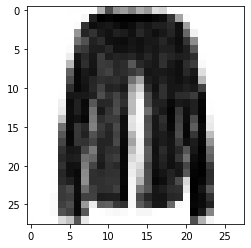

In [20]:
# How do the images look like?
random_idx = np.random.choice(images.shape[0], 1)
image_1 = images[random_idx].reshape(28, 28)
plt.imshow(image_1, cmap=plt.cm.binary)
plt.show()

## Forming adversarial examples

- Train an image classifier
- Form examples

In [0]:
# Define a utility function for the image classifier
def get_train_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3, 3), activation='relu')
    ])

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    return model

In [23]:
# Load the dataset again
((X_train, y_train), (X_test, y_test)) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalize the dataset
X_train = X_train / 255.
X_test = X_test / 255.

# Train the model
apparel_model = get_train_model()
history = apparel_model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  batch_size=128,
                  epochs=10)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.6266 - accuracy: 0.7707 - val_loss: 0.4383 - val_accuracy: 0.8426
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3936 - accuracy: 0.8590 - val_loss: 0.3717 - val_accuracy: 0.8689
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3366 - accuracy: 0.8773 - val_loss: 0.3378 - val_accuracy: 0.8768
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3023 - accuracy: 0.8899 - val_loss: 0.3114 - val_accuracy: 0.8879
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2772 - accuracy: 0.8987 - val_loss: 0.2831 - val_accuracy: 0.8976
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2554 - accuracy: 0.9061 - val_loss: 0.2868 - val_accuracy: 0.8981
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2396 - accuracy: 0.9118 - val_loss: 0.2729 - val_accuracy: 0.9005
Epoch 

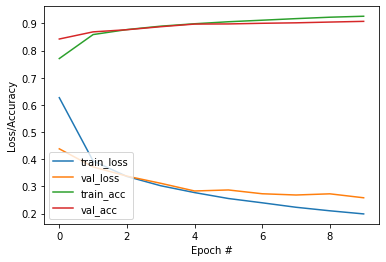

In [27]:
# Plot training progress
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [0]:
# Define class labels
LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [0]:
# Create adversarial example
############################

# Clipping utility so that the pixel values stay within [0,1]
EPS = 1./10000

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS)

def generate_adversaries_targeted(image_tensor, delta, 
    true_index, target_index, model):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-1)

    for t in range(300):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = (image_tensor + delta)/255
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta

def perturb_image(image, true, target, model):
    # Load and preprocess image but a but without any `preprocess_input`
    plt.imshow((image.reshape(28, 28)), cmap=plt.cm.binary)

    # Add batch dim
    image = np.expand_dims(image, 0)

    # Generate predictions before any adversaries
    unsafe_preds = model.predict(image)
    print('Predicted before adv.:', LABELS[unsafe_preds[0].argmax()])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(image*255, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries_targeted(image_tensor, delta, true, target, model)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255, cmap=plt.cm.binary)
    plt.show()

    # Generate prediction
    perturbed_image = (image_tensor + delta_tensor)/255
    preds = model.predict(perturbed_image)
    print('Predicted:', LABELS[preds[0].argmax()])

    return (image_tensor + delta_tensor)/255

Original label  T-shirt/top
Predicted before adv.: T-shirt/top


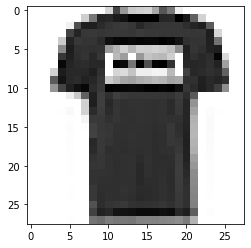

0 16.117859
20 16.117216
40 16.099031
60 12.984386
80 9.905032
100 6.4673576
120 3.6043863
140 1.7249596
160 0.06058836
180 -1.2979188
200 -2.7338905
220 -4.0762415
240 -6.040269
260 -8.053326
280 -10.19889


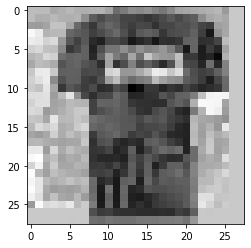

Predicted: Sandal


In [82]:
# Randomly select an image
idx = int(np.random.choice(X_train.shape, 1))
sample_image = X_train[idx]

# Let's go (target -> Sandal (idx: 5))
print("Original label ",LABELS[y_train[idx]])
perturbed_image = perturb_image(sample_image, y_train[idx], 5, apparel_model)

## Seeing if the adversarial examples are misclassified by the Discriminator of the GAN

In [85]:
# 0 -> Real image 1-> Fake image
disc.predict_classes(perturbed_image)

array([[1]], dtype=int32)

The generator is able to predict the perturbed image as a fake one. **But this does not draw any conclusion since we used a relatively simple and small dataset.**